In [2]:
# build 3d dataset:
import numpy as np

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [4]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

The more dimensions a training set has, the greater the risk of overfitting.

## Main Approaches for Dimensionality Reduction

- Projection: PCA and Kernel PCA
- Manifold Learning: LLE

### PCA
Principal Component Analysis

First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it.

### Preserving the Variance

Select the axis that preserves the maximum amount of variance, as it will most likely lose less information than the other projections. This is the axis that minimizes the mean squared distance between the original dataset and its projection onto that axis.

In [5]:
from sklearn.decomposition import PCA, KernelPCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [6]:
X2D[:5]

array([[ 122.2540649 , -316.27296051],
       [1010.49384586, -289.97205546],
       [ -58.99615423,  393.66119088],
       [-796.96383368, -607.41218864],
       [-391.31918299,  729.83684724]])

### Explained Variance
The ratio indicates the proportion of the dataset’s variance that lies along each principal component.

In [6]:
pca.explained_variance_ratio_ #explained variance of the first 2 components of the 3D dataset

array([0.09746116, 0.07155445])

This output tells us that 84.2% of the dataset’s variance lies along the first PC, and 14.6% lies along the second PC. This leaves less than 1.2% for the third PC, so it is reasonable to assume that the third PC probably carries little information.

### Choosing the Right Number of Dimensions

In [7]:
# computes the minimum number of dimensions required to preserve 95% of the training set’s variance:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [8]:
d

154

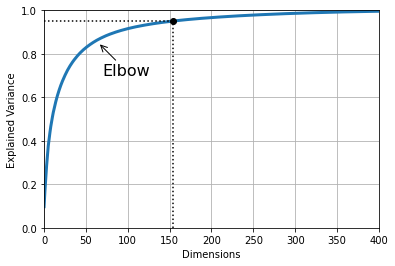

In [9]:
from matplotlib import pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

In [10]:
# simpler way:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [11]:
pca.n_components_

154

In [12]:
np.sum(pca.explained_variance_ratio_)

0.9503684424557436

### PCA for Compression

In [13]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [14]:
import matplotlib as mpl

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

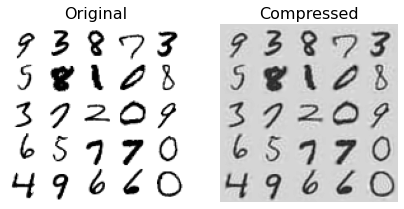

In [15]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

### Randomized PCA

If you set the svd_solver hyperparameter to "randomized", Scikit-Learn uses a stochastic algorithm called Randomized PCA that quickly finds an approximation of the first d principal components.

It is dramatically faster than full SVD when d is much smaller than n:

In [16]:
rnd_pca = PCA(n_components=154, svd_solver='randomized')
X_reduced = rnd_pca.fit_transform(X_train)

### Incremental PCA

Allow you to split the training set into mini-batches and feed an IPCA algorithm one mini-batch at a time.

This is useful for large training sets and for applying PCA online (i.e., on the fly, as new instances arrive).

In [17]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="")
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

Take a look at the book's notebook for chapter 8. It has more details about using memmap() that can be pretty useful.

## Kernel PCA

In [1]:
# This part is killing the notebook kernel.
# The problem seems to be related to KernelPCA and Numpy.
# I might need to refresh my virtual environment.
# Note: it is working on google colab

# from sklearn.decomposition import KernelPCA

# rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
# X_reduced = rbf_pca.fit_transform(X)

In [3]:
# Resuming the study on google colab for this chapter. 